In [1]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multidist_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle

In [2]:
# loading notes csv
notes = pd.read_csv('notes.csv')

In [3]:
notes

,Sno,Wall Dist,T2T Dist,T1-E Dist,T2-E Dist
0,0,18.0,112,NaN,NaN
1,1,18.0,112,NaN,NaN
2,2,18.0,112,NaN,NaN
3,3,33.0,112,NaN,NaN
4,4,33.0,112,NaN,NaN
5,5,33.0,112,NaN,NaN
6,6,47.5,112,NaN,NaN
7,7,47.5,112,NaN,NaN
8,8,47.5,112,NaN,NaN
9,9,60.0,112,NaN,NaN


In [4]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    T2Tdist=float(notes[notes['Sno']==dist_idx]['T2T Dist'].iloc[0])
    wallDist=float(notes[notes['Sno']==dist_idx]['Wall Dist'].iloc[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        # Add new columns to _df for all rows
        _df['Run Exp Num'] = dist_idx
        _df['dist'] = T2Tdist/100
        _df['wall dist'] = wallDist/100
        if df_all is None:
            df_all=_df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)

df_all

0.df
1.df
2.df
3.df
4.df
5.df
6.df
7.df
8.df
9.df
10.df
11.df
12.df
13.df
14.df
15.df
16.df
17.df
18.df
19.df
20.df
21.df
22.df
23.df
24.df
25.df
26.df
27.df
28.df
29.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs,dist,wall dist
0,Tag1,Tag2,1.759250e+09,1.759250e+09,"[252.04, 412.57, 413.25, 412.11, 413.56, 413.1...",775,0,5,1.12,0.180
1,Tag2,Tag1,1.759250e+09,1.759250e+09,"[143.09, 30.86, 30.79, 31.24, 30.63, 30.86, 31...",775,0,5,1.12,0.180
2,Tag1,Tag2,1.759250e+09,1.759250e+09,"[411.65, 338.86, 340.24, 340.62, 339.7, 339.63...",785,0,5,1.12,0.180
3,Tag2,Tag1,1.759250e+09,1.759250e+09,"[31.17, 50.32, 50.39, 50.62, 50.77, 50.62, 50....",785,0,5,1.12,0.180
4,Tag1,Tag2,1.759250e+09,1.759250e+09,"[339.32, 246.85, 246.7, 246.47, 246.47, 246.17...",795,0,5,1.12,0.180
...,...,...,...,...,...,...,...,...,...,...
1375,Tag2,Tag1,1.759261e+09,1.759261e+09,"[27.5, 35.36, 35.36, 35.36, 35.36, 34.98, 35.3...",975,29,5,1.12,1.535
1376,Tag1,Tag2,1.759261e+09,1.759261e+09,"[92.89, 37.73, 37.42, 37.65, 37.58, 37.42, 37....",985,29,5,1.12,1.535
1377,Tag2,Tag1,1.759261e+09,1.759261e+09,"[30.33, 18.5, 18.35, 18.88, 18.27, 18.5, 18.35...",985,29,5,1.12,1.535
1378,Tag1,Tag2,1.759261e+09,1.759261e+09,"[37.27, 18.35, 18.96, 18.04, 18.58, 18.73, 18....",995,29,5,1.12,1.535


In [5]:
time_per_phase = 10/1000  # s
num_phases=6
num_mpps=df_all.iloc[0]['NumMPPs']
sampling_rate=1000
plotting=False
ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
                                "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])

if plotting:
    plt.figure(figsize=(15,20))

unique_exp_no=0
phase_order=[1,3,4,6,7,8]

for df_idx in range(len(df_all)):

    voltages=df_all.iloc[df_idx]['Voltages (mV)']
    phase_medians={
        1:[],
        3:[],
        4:[],
        6:[],
        7:[],
        8:[],
    }
    for idx,v in enumerate(ver_lines):
        if idx<len(ver_lines)-1:
            phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
        if plotting:
            plt.subplot(len(df_all)//3+1, 3, df_idx+1)
            if idx%num_phases==0:
                plt.axvline(x=v, color='b', linestyle='-')
            else:
                plt.axvline(x=v, color='r', linestyle='--')
    entry={
        "Rx": df_all.iloc[df_idx]["Rx"],
        "Tx":df_all.iloc[df_idx]["Tx"],
        "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
        "Phase1":phase_medians[1],
        "Phase3":phase_medians[3],
        "Phase4":phase_medians[4],
        "Phase6":phase_medians[6],
        "Phase7":phase_medians[7],
        "Phase8":phase_medians[8],
        "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
        "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
        "Dist (m)":df_all.iloc[df_idx]["dist"],
        "Wall Dist (m)":df_all.iloc[df_idx]["wall dist"],
        "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
    }
    for phase in phase_order:
        entry_aggregated={
            "Rx":df_all.iloc[df_idx]["Rx"],
            "Tx":df_all.iloc[df_idx]["Tx"],
            "phase": str(phase),
            "median": np.mean(phase_medians[phase]), # mean of medians
            "std": np.std(phase_medians[phase]),
            "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
            "dist":df_all.iloc[df_idx]["dist"],
            "wall dist":df_all.iloc[df_idx]["wall dist"],
            'delta': max(phase_medians[phase])-min(phase_medians[phase]),
            "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
            "Unique Exp Number":unique_exp_no,
            "allVoltages": phase_medians[phase]
        }
        processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
    unique_exp_no+=1
    
    # Identify and print bad MPPs
    bad=False
    for k in phase_medians.keys():
        assert(len(phase_medians[k])==num_mpps)
        if np.std(phase_medians[k])>1:
            d=df_all.iloc[df_idx]["wall dist"]
            print(f"<== Bad data found at {df_idx} df_idx at phase {k} at T2T dist {d}.", end="\t")
            print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
    
    processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    if plotting:
        plt.plot(voltages,'.')
        plt.title(df_idx)
        plt.tight_layout()
        
if plotting:
    plt.show()
    

    

<== Bad data found at 8 df_idx at phase 1 at T2T dist 0.18.	Num vals: 5, mean: 110.04099999999998, stdev: 1.0005118689950672 ==>
<== Bad data found at 8 df_idx at phase 3 at T2T dist 0.18.	Num vals: 5, mean: 110.68999999999998, stdev: 1.016602183747408 ==>
<== Bad data found at 8 df_idx at phase 6 at T2T dist 0.18.	Num vals: 5, mean: 108.643, stdev: 1.1121133035801716 ==>
<== Bad data found at 8 df_idx at phase 8 at T2T dist 0.18.	Num vals: 5, mean: 109.726, stdev: 1.1138015981313738 ==>
<== Bad data found at 24 df_idx at phase 4 at T2T dist 0.18.	Num vals: 5, mean: 701.327, stdev: 1.0010973978589743 ==>


/var/folders/hm/7p8fzz2x2y10pbydpxcs7vw00000gn/T/ipykernel_15476/2988462823.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)


<== Bad data found at 81 df_idx at phase 1 at T2T dist 0.18.	Num vals: 5, mean: 251.025, stdev: 1.9807347121712184 ==>
<== Bad data found at 81 df_idx at phase 3 at T2T dist 0.18.	Num vals: 5, mean: 262.50800000000004, stdev: 1.7439197229230554 ==>
<== Bad data found at 81 df_idx at phase 4 at T2T dist 0.18.	Num vals: 5, mean: 248.43200000000002, stdev: 2.041346614370029 ==>
<== Bad data found at 81 df_idx at phase 6 at T2T dist 0.18.	Num vals: 5, mean: 252.002, stdev: 2.219931530475659 ==>
<== Bad data found at 81 df_idx at phase 7 at T2T dist 0.18.	Num vals: 5, mean: 255.132, stdev: 2.2502813157469914 ==>
<== Bad data found at 81 df_idx at phase 8 at T2T dist 0.18.	Num vals: 5, mean: 259.86100000000005, stdev: 2.0267298784001833 ==>
<== Bad data found at 83 df_idx at phase 1 at T2T dist 0.18.	Num vals: 5, mean: 179.844, stdev: 1.422151187462152 ==>
<== Bad data found at 83 df_idx at phase 3 at T2T dist 0.18.	Num vals: 5, mean: 188.167, stdev: 1.6716297436932677 ==>
<== Bad data found

In [6]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs,Dist (m),Wall Dist (m)
0,Tag1,Tag2,"[252.04, 412.57, 413.25, 412.11, 413.56, 413.1...","[412.64, 412.645, 412.41499999999996, 412.26, ...","[412.905, 412.83500000000004, 413.1, 412.83000...","[414.78, 414.58500000000004, 414.13, 413.79, 4...","[414.36, 413.98, 413.75, 413.37, 413.37]","[412.87, 412.95, 412.605, 412.18, 412.145]","[412.49, 412.985, 412.185, 411.91999999999996,...",775,0,5,1.12,0.180
1,Tag2,Tag1,"[143.09, 30.86, 30.79, 31.24, 30.63, 30.86, 31...","[30.86, 30.71, 30.71, 30.71, 31.130000000000003]","[30.56, 30.71, 30.79, 31.05, 31.130000000000003]","[31.4, 31.509999999999998, 31.435, 31.85, 31.89]","[33.42, 33.265, 33.3, 33.644999999999996, 33.42]","[32.425, 32.16, 32.31, 32.54, 32.5]","[30.825, 30.75, 30.785, 31.17, 31.05]",775,0,5,1.12,0.180
2,Tag1,Tag2,"[411.65, 338.86, 340.24, 340.62, 339.7, 339.63...","[340.24, 339.74, 340.20000000000005, 340.16, 3...","[341.115, 340.845, 341.115, 341.54, 341.304999...","[344.82, 345.275, 344.395, 344.66, 344.36]","[339.475, 338.98, 339.16999999999996, 339.0549...","[338.9, 339.09, 338.71, 338.94, 338.825]","[339.205, 339.555, 339.4, 339.16999999999996, ...",785,0,5,1.12,0.180
3,Tag2,Tag1,"[31.17, 50.32, 50.39, 50.62, 50.77, 50.62, 50....","[50.55, 50.62, 50.55, 50.7, 51.04]","[50.125, 50.355000000000004, 50.35500000000000...","[52.185, 52.07, 52.07, 52.15, 52.26]","[52.644999999999996, 52.57, 52.68, 52.87, 52.95]","[49.44, 49.25, 49.705, 49.71, 49.67]","[49.48, 49.32, 49.705, 49.94, 49.745000000000005]",785,0,5,1.12,0.180
4,Tag1,Tag2,"[339.32, 246.85, 246.7, 246.47, 246.47, 246.17...","[246.7, 246.585, 247.57999999999998, 247.73000...","[246.93, 247.08, 248.305, 248.305, 248.6050000...","[249.03, 248.99, 250.055, 249.83, 249.98]","[245.94, 245.745, 246.32, 246.55, 246.74]","[245.745, 245.56, 246.7, 246.85500000000002, 2...","[246.435, 246.55, 247.195, 247.425, 247.5]",795,0,5,1.12,0.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,Tag2,Tag1,"[27.5, 35.36, 35.36, 35.36, 35.36, 34.98, 35.3...","[35.36, 35.29, 35.17, 37.235, 37.8]","[36.81, 36.81, 37.27, 36.735, 37.385]","[32.425, 32.08, 33.455, 32.39, 33.225]","[30.48, 30.405, 31.7, 31.855, 31.895]","[29.91, 29.49, 31.05, 30.060000000000002, 29.87]","[30.365000000000002, 30.365, 30.48, 30.975, 31...",975,29,5,1.12,1.535
1376,Tag1,Tag2,"[92.89, 37.73, 37.42, 37.65, 37.58, 37.42, 37....","[37.58, 37.42, 37.305, 37.19, 37.12]","[37.04, 36.89, 36.85, 36.925, 37.12]","[36.2, 36.315, 36.58, 36.43, 36.35]","[37.19, 37.12, 37.345, 37.230000000000004, 37.27]","[37.385000000000005, 37.35, 37.614999999999995...","[37.35, 37.46, 37.69, 37.269999999999996, 37.35]",985,29,5,1.12,1.535
1377,Tag2,Tag1,"[30.33, 18.5, 18.35, 18.88, 18.27, 18.5, 18.35...","[18.5, 18.35, 20.295, 19.07, 19.3]","[18.81, 19.495, 19.91, 19.04, 19.415]","[17.32, 18.96, 17.665, 17.89, 18.119999999999997]","[16.365000000000002, 18.04, 17.585, 18.235, 17...","[16.215, 18.04, 16.29, 15.870000000000001, 15....","[15.75, 15.68, 15.79, 15.83, 16.705]",985,29,5,1.12,1.535
1378,Tag1,Tag2,"[37.27, 18.35, 18.96, 18.04, 18.58, 18.73, 18....","[18.58, 18.575, 18.5, 18.465, 18.310000000000002]","[18.465, 18.39, 18.27, 18.39, 18.27]","[18.58, 18.65, 18.65, 18.73, 18.58]","[18.88, 18.73, 18.615, 18.54, 18.5]","[18.575, 18.73, 18.54, 18.54, 18.54]","[18.81, 18.65, 18.39, 18.39, 18.5]",995,29,5,1.12,1.535


In [7]:
with open("processedDF_aggregated.pkl", 'wb') as f:
    pickle.dump(processedDF_aggregated,f)
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,wall dist,allVoltages
0,Tag1,Tag2,1,412.322,0.365932,775000000.0,1.12,0.995,0,0,0.180,"[412.64, 412.645, 412.41499999999996, 412.26, ..."
1,Tag1,Tag2,3,412.877,0.127067,775000000.0,1.12,0.385,0,0,0.180,"[412.905, 412.83500000000004, 413.1, 412.83000..."
2,Tag1,Tag2,4,414.153,0.482697,775000000.0,1.12,1.300,0,0,0.180,"[414.78, 414.58500000000004, 414.13, 413.79, 4..."
3,Tag1,Tag2,6,413.766,0.377497,775000000.0,1.12,0.990,0,0,0.180,"[414.36, 413.98, 413.75, 413.37, 413.37]"
4,Tag1,Tag2,7,412.550,0.336556,775000000.0,1.12,0.805,0,0,0.180,"[412.87, 412.95, 412.605, 412.18, 412.145]"
...,...,...,...,...,...,...,...,...,...,...,...,...
8275,Tag2,Tag1,3,8.157,0.097396,995000000.0,1.12,0.305,29,1379,1.535,"[8.315, 8.165, 8.13, 8.01, 8.165]"
8276,Tag2,Tag1,4,7.898,0.124764,995000000.0,1.12,0.380,29,1379,1.535,"[7.67, 7.9350000000000005, 8.05, 7.9, 7.935000..."
8277,Tag2,Tag1,6,7.804,0.114298,995000000.0,1.12,0.340,29,1379,1.535,"[7.74, 7.82, 7.86, 7.97, 7.63]"
8278,Tag2,Tag1,7,7.355,0.197535,995000000.0,1.12,0.575,29,1379,1.535,"[7.67, 7.21, 7.44, 7.36, 7.095]"


In [8]:
lambda_ = 3e8/915e6
th_phi = 2*np.pi*(112/100)/lambda_
th_phi = th_phi % (np.pi)

In [9]:
voltage_txT1={}
voltage_txT2={}
for idx in range(processedDF_aggregated.shape[0]):
    wall_dist=processedDF_aggregated.iloc[idx]["wall dist"]
    voltages=processedDF_aggregated.iloc[idx]["allVoltages"]
    if processedDF_aggregated.iloc[idx]["Tx"]=="Tag1":
        if wall_dist not in voltage_txT1:
            voltage_txT1[wall_dist]=np.array([])
        voltage_txT1[wall_dist]=np.concat([voltage_txT1[wall_dist], np.array(voltages)])
    else:
        if wall_dist not in voltage_txT2:
            voltage_txT2[wall_dist]=np.array([])
        voltage_txT2[wall_dist]=np.concat([voltage_txT2[wall_dist], np.array(voltages)])
        
avg_voltage_txT1={}
avg_voltage_txT2={}

for k in voltage_txT1.keys():
    avg_voltage_txT1[k]=np.mean(voltage_txT1[k])
    avg_voltage_txT2[k]=np.mean(voltage_txT2[k])

In [10]:
freq_range=np.array(range(775,1000,10))*1e6
# freq_range=np.array([915])*1e6
all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors, \
    selected_experiments_all = multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False)

with open("no_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)    

with open("theoretical_phase.pkl",'wb') as f:
    pickle.dump(all_freqs_theoretical,f)    

[-0.8833533017153286, -1.4439809269263129]
[-1.185795404711732, -1.5331636744681263]
[-0.9595428250993314, -1.634512523149371]
[-0.06012193787202582, -0.5984590559700962]
[-0.06473926696218905, -0.5847200080858376]
[-0.058116445508952584, -0.5682335218168688]
[-0.040014730545697944, 0.3662277460407658]
[-0.0397029766354589, 0.3741317582161129]
[-0.03352895875972737, 0.19005323739069774]
[-0.3284561199496498, -0.5057265051396291]
[-0.29493814335443785, -0.39068898474432306]
[-0.3150451467542741, -0.4603362582498294]
[-0.02049746468488514, 0.04275481280161535]
[-0.002293440872026728, 0.0737132730381763]
[0.0015219072921376431, 0.02237301749061612]
[0.01249940424295525, -0.26288900954830724]
[-0.006430825756642793, -0.22976881797225213]
[0.002472688927723226, -0.23364261981605328]
[0.04169861812056276, -0.21708296136115704]
[0.03232329617244723, -0.2034939102105909]
[0.03163950261840426, -0.27532584040900426]
[-0.08189888198817856, -0.0481435538387207]
[-0.09402038107909143, -0.0305197390

In [11]:
x=[]
for i in processedDF_aggregated["wall dist"].unique():
    x+=[i]*3

In [12]:
len(all_freqs[915e6][1.12])

30

Text(0, 0.5, 'Phase (deg)')

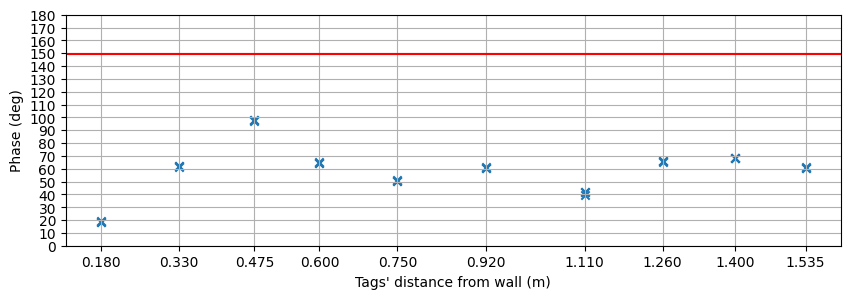

In [13]:
plt.figure(figsize=(10,3))
plt.scatter(x, np.rad2deg(all_freqs[915e6][1.12]), marker='x')
plt.axhline(y=np.rad2deg(th_phi), color='r', linestyle='-', label="expected phase")
plt.xticks(processedDF_aggregated["wall dist"].unique())
plt.yticks(np.arange(0,181,10))
plt.grid()

plt.xlabel("Tags' distance from wall (m)")
plt.ylabel("Phase (deg)")


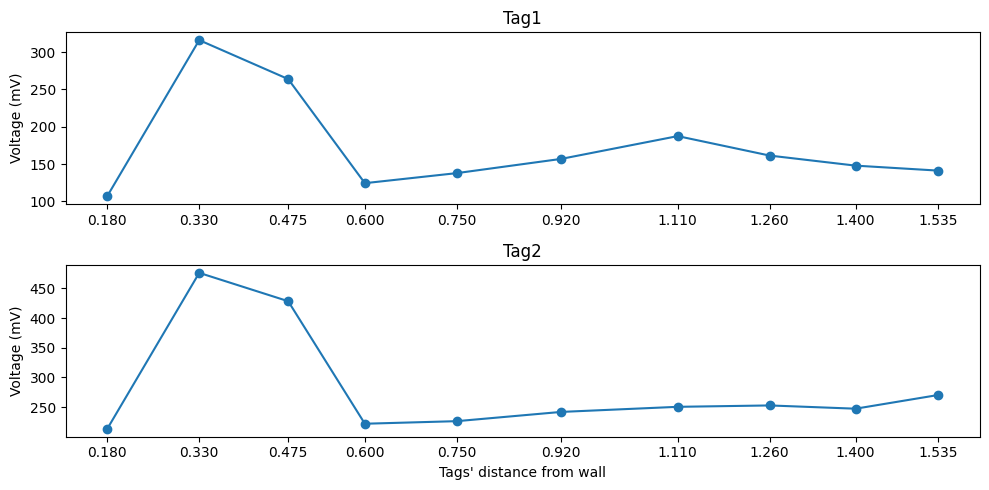

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(avg_voltage_txT1.keys(), avg_voltage_txT1.values(), 'o-')
plt.xticks(processedDF_aggregated["wall dist"].unique())
plt.title("Tag1")
plt.ylabel("Voltage (mV)")
plt.subplot(2,1,2)
plt.plot(avg_voltage_txT2.keys(), avg_voltage_txT2.values(),'o-')
plt.xticks(processedDF_aggregated["wall dist"].unique())
plt.title("Tag2")
plt.xlabel("Tags' distance from wall")
plt.ylabel("Voltage (mV)")

plt.tight_layout()
plt.show()

### With offset correction using the ground truth.

In [15]:
# correction_offsets={}
# all_errors=None


# all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, _,_=\
#     multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False)


# for freq in freq_range:
#     offset,best_error,errors=get_offset(all_freqs[freq],freq)
#     # print(f"Freq {freq//1e6};\t Mean:{np.mean(errors)};\t Median:{np.median(errors)};\t Std:{np.std(errors)}")
#     # if all_errors is None:
#     #     all_errors=errors
#     # else:
#     #     all_errors=np.concat((all_errors,errors))
#     correction_offsets[freq]=offset



# all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
#     multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


# with open("gt_correction_all_errs.pkl",'wb') as f:
#     pickle.dump(all_errors,f)
    
# with open("gt_correction_all_phases.pkl",'wb') as f:
#     pickle.dump(all_freqs,f)

# with open("gt_correction_all_phases_unwrapped.pkl",'wb') as f:
#     pickle.dump(all_freqs_unwrapped,f)    

### With correction offsets from pretrained

In [16]:
correction_offsets=pickle.load(open("/Users/manavjeet/git/T2TExperiments/DistExperiments/correction_offsets.pkl",'rb'))

all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=False)


with open("pretrained_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("pretrained_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("pretrained_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)

[-0.8833533017153286, -1.4439809269263129]
[-1.185795404711732, -1.5331636744681263]
[-0.9595428250993314, -1.634512523149371]
[-0.06012193787202582, -0.5984590559700962]
[-0.06473926696218905, -0.5847200080858376]
[-0.058116445508952584, -0.5682335218168688]
[-0.040014730545697944, 0.3662277460407658]
[-0.0397029766354589, 0.3741317582161129]
[-0.03352895875972737, 0.19005323739069774]
[-0.3284561199496498, -0.5057265051396291]
[-0.29493814335443785, -0.39068898474432306]
[-0.3150451467542741, -0.4603362582498294]
[-0.02049746468488514, 0.04275481280161535]
[-0.002293440872026728, 0.0737132730381763]
[0.0015219072921376431, 0.02237301749061612]
[0.01249940424295525, -0.26288900954830724]
[-0.006430825756642793, -0.22976881797225213]
[0.002472688927723226, -0.23364261981605328]
[0.04169861812056276, -0.21708296136115704]
[0.03232329617244723, -0.2034939102105909]
[0.03163950261840426, -0.27532584040900426]
[-0.08189888198817856, -0.0481435538387207]
[-0.09402038107909143, -0.0305197390

Text(0, 0.5, 'Phase (deg)')

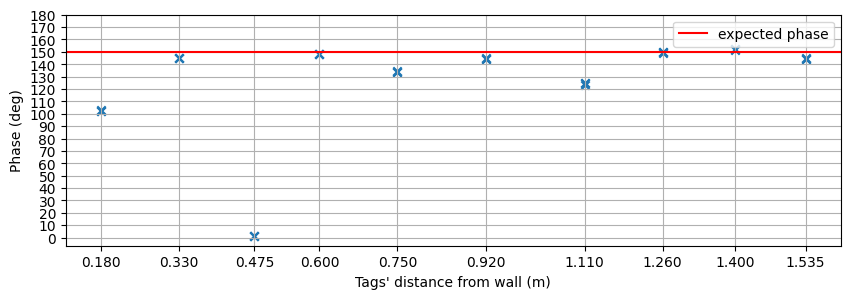

In [17]:
plt.figure(figsize=(10,3))
plt.axhline(y=np.rad2deg(th_phi), color='r', linestyle='-', label="expected phase")
plt.scatter(x, np.rad2deg(all_freqs[915e6][1.12]), marker='x')
plt.xticks(processedDF_aggregated["wall dist"].unique())
plt.yticks(np.arange(0,181,10))
plt.legend()
plt.grid()

plt.xlabel("Tags' distance from wall (m)")
plt.ylabel("Phase (deg)")


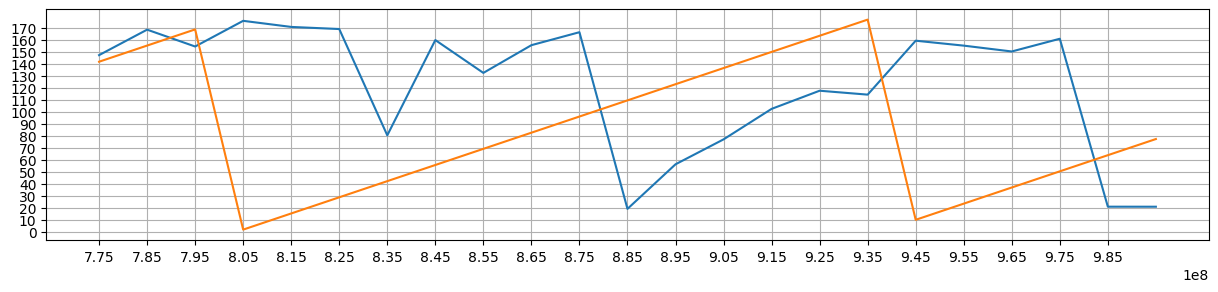

In [18]:
plt.figure(figsize=[15,3])
plt.plot(all_freqs.keys(),np.rad2deg([x[1.12][0] for x in all_freqs.values()]))
plt.plot(all_freqs.keys(),np.rad2deg([(2*np.pi*1.12*x/3e8)%np.pi for x in all_freqs.keys()]))
plt.xticks(np.arange(775,995,10)*1e6)
plt.yticks(np.arange(0,180,10))
plt.grid()
plt.show()

In [19]:
slope=np.deg2rad(100)/40e6

dist=(3e8/(2*np.pi))*slope
print(dist)

2.0833333333333335
